In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import eurec4a

In [201]:
# cat = eurec4a.get_intake_catalog()
# list(cat)
# ds = cat.c3ontext.level3_IR_daily.to_dask()

# TODO email Hauke to ask why this isn't working properly. Loading data locally instead...

ds = xr.open_zarr('processed_data/EUREC4A_ManualClassifications_l3_IR_instant.zarr')
ds
# Time interval is every two hours (you have every 30 min)

<xarray.Dataset>
Dimensions:    (date: 564, longitude: 2200, latitude: 1500, pattern: 5)
Coordinates:
  * date       (date) datetime64[ns] 2020-01-07 ... 2020-02-22T22:00:00
  * latitude   (latitude) float64 20.0 19.99 19.98 19.97 ... 5.03 5.02 5.01 5.0
  * longitude  (longitude) float64 -62.0 -61.99 -61.98 ... -40.02 -40.01 -40.0
  * pattern    (pattern) object 'Sugar' 'Flowers' 'Fish' 'Gravel' 'Unclassified'
Data variables:
    freq       (date, longitude, latitude, pattern) float64 dask.array<chunksize=(1, 2200, 1500, 5), meta=np.ndarray>
    nb_users   (date) float64 dask.array<chunksize=(564,), meta=np.ndarray>
Attributes:
    author:          Hauke Schulz (hauke.schulz@mpimet.mpg.de)
    created_on:      2022-02-06 08:32 UTC
    created_with:    create_level3.py with its last modification on Sun Feb  ...
    description:     Level-3: instant classification frequency
    doi:             10.5281/zenodo.5979718
    institute:       Max Planck Institut für Meteorologie, Germany
    python_version:  3.8.6 | packaged by conda-forge | (default, Nov 27 2020,...
    title:           EUREC4A: manual meso-scale cloud pattern classifications
    version:         v0.4.0

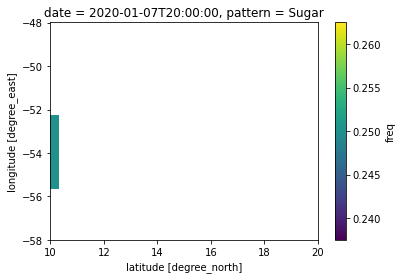

In [202]:
lat0, lat1, lon0, lon1 = [10, 20, -58, -47.99] # See cloudmetrics-goes16-IR.ipynb

test_scene = ds.freq.isel(date=10).sel(latitude=slice(lat1, lat0), longitude=slice(lon0,lon1))
test_scene.sel(pattern='Sugar').plot()

In [203]:
# What is coverage fraction for each pattern in this scene?
freq_threshold = 0.1 # Hauke says it's a pattern if 10% of participants agree

for pat in ds.pattern:
    freq = test_scene.sel(pattern=pat).values
    
    frac = (np.count_nonzero(freq[np.isreal(freq)] > freq_threshold)
            / (test_scene.latitude.size * test_scene.longitude.size))

    print(pat.values, ":", frac)

Sugar : 0.011514485514485515
Flowers : 0.0
Fish : 0.352
Gravel : 0.40557542457542456
Unclassified : 1.0


But what do you do if these add up to more than 1? Just accept a patch can be in multiple classes at the same time?

In [204]:
# Compute coverage fraction for each scene, following
# https://github.com/observingClouds/C3ONTEXT/blob/fa2740aac9a7b1e7287b32651db9737f93ee4c57/scripts/calculate_agreement.py

load_df = True

if load_df:
    df_sgff = pd.read_hdf('df_sgff.h5')
else:
    df_sgff = pd.DataFrame(index=ds['date'], columns=ds['pattern'].values)
df_sgff

,Sugar,Flowers,Fish,Gravel,Unclassified
2020-01-07 00:00:00,0.0,0.0,0.0,0.0,0.0
2020-01-07 02:00:00,0.122542,0.0,0.0,0.336788,1.0
2020-01-07 04:00:00,0.04515,0.0,0.480847,0.71187,1.0
2020-01-07 06:00:00,0.0,0.0,0.0,0.116768,1.0
2020-01-07 08:00:00,0.0,0.804581,0.0,0.461145,1.0
...,...,...,...,...,...
2020-02-22 14:00:00,0.139175,0.328364,0.204725,0.432915,1.0
2020-02-22 16:00:00,0.25984,0.0,0.143473,0.518182,1.0
2020-02-22 18:00:00,0.0,0.0,0.0,0.776501,1.0
2020-02-22 20:00:00,0.371014,0.0,0.0,0.500798,1.0


In [166]:
for i in range(len(ds['date'])):
    print('Processing ', ds['date'][i].data, 'scene ', i+1, '/', len(ds['date']))
    
    scene = ds.freq.isel(date=i).sel(latitude=slice(lat1, lat0), longitude=slice(lon0,lon1))
    
    for pat in ds.pattern:
        freq = scene.sel(pattern=pat).values

        frac = (np.count_nonzero(freq[np.isreal(freq)] > freq_threshold)
                / (scene.latitude.size * scene.longitude.size))
        
        print(pat.values, ":", frac)
        df_sgff.iloc[i].loc[str(pat.values)] = frac
    df_sgff.to_hdf('df_sgff.h5', 'sgff', mode='w')

Processing  2020-01-07T00:00:00.000000000 scene  1 / 564
Sugar : 0.0
Flowers : 0.0
Fish : 0.0
Gravel : 0.0
Unclassified : 0.0
Processing  2020-01-07T02:00:00.000000000 scene  2 / 564


/home/WUR/janss254/my_envs/c3ontext/lib/python3.7/site-packages/pandas/core/generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block0_values] [items->Index(['Sugar', 'Flowers', 'Fish', 'Gravel', 'Unclassified'], dtype='object')]

  encoding=encoding,


Sugar : 0.12254245754245754
Flowers : 0.0
Fish : 0.0
Gravel : 0.3367882117882118
Unclassified : 1.0
Processing  2020-01-07T04:00:00.000000000 scene  3 / 564
Sugar : 0.04514985014985015
Flowers : 0.0
Fish : 0.48084715284715285
Gravel : 0.7118701298701299
Unclassified : 1.0
Processing  2020-01-07T06:00:00.000000000 scene  4 / 564
Sugar : 0.0
Flowers : 0.0
Fish : 0.0
Gravel : 0.11676823176823177
Unclassified : 1.0
Processing  2020-01-07T08:00:00.000000000 scene  5 / 564
Sugar : 0.0
Flowers : 0.8045814185814186
Fish : 0.0
Gravel : 0.46114485514485515
Unclassified : 1.0
Processing  2020-01-07T10:00:00.000000000 scene  6 / 564
Sugar : 0.0
Flowers : 0.7831428571428571
Fish : 0.0
Gravel : 0.06559840159840159


KeyboardInterrupt: 

In [205]:
# Get daily mean coverage fraction

df_sgff.index.rename('date', inplace=True)
ds_sgff = df_sgff.to_xarray()

# FIXME xarray cannot do this on all data variables at the same time for reasons that remain unclear -> Loop instead
def ds_date_mean(ds):
    keys = [i for i in ds.data_vars]
    for i in range(len(keys)):
        if i == 0:
            ds_date = ds[keys[i]].groupby('date.date').mean()
        else:
            ds_date = xr.merge([ds_date, ds[keys[i]].groupby('date.date').mean()])
    return ds_date

ds_sgff_date = ds_date_mean(ds_sgff)
ds_sgff_date

<xarray.Dataset>
Dimensions:       (date: 47)
Coordinates:
  * date          (date) object 2020-01-07 2020-01-08 ... 2020-02-21 2020-02-22
Data variables:
    Sugar         (date) float64 0.03436 0.2112 0.1044 ... 0.08972 0.2032
    Flowers       (date) float64 0.2537 0.4031 0.478 ... 0.678 0.2122 0.02736
    Fish          (date) float64 0.1112 0.007615 0.2291 ... 0.07972 0.0959
    Gravel        (date) float64 0.2081 0.323 0.5865 ... 0.08539 0.183 0.3583
    Unclassified  (date) float64 0.9167 1.0 0.9339 0.9398 ... 1.0 1.0 1.0 1.0

In [206]:
# Get daily mean location in pattern space (from cloudmetrics-c3ontext notebook)

from Postprocess import analysis, utils
from sklearn.decomposition import PCA

metrics = ['cloud_fraction',
           'fractal_dimension',
           'open_sky',
           'cop',
           'iorg',
           'scai',
           'max_length_scale',
           'mean_eccentricity',
           'mean_length_scale',
           'mean_perimeter_length',
           'num_objects',
           'orientation',
           'spectral_length_moment',
           'spectral_anisotropy',
           'spectral_slope',
           'woi1',
           'woi2',
           'woi3'
          ]

# Read from file
df_metrics_pp = pd.read_hdf('df_metrics.h5')

# Filter scenes which miss metrics
nan_filter = metrics
for ind in nan_filter:
    df_metrics_pp = df_metrics_pp[df_metrics_pp[ind].notna()]
# print(df_metrics_pp.isna().any())

# Standardise metrics
data = df_metrics_pp.to_numpy()
data = utils.stand(data)
    
# Compute PCA
pca = PCA()
x_pca = pca.fit_transform(data)

# Stick in df -> ds -> subset by date
df_pca = pd.DataFrame(index=df_metrics_pp.index, data=x_pca)
df_pca.index.rename('date', inplace=True)

ds_pca = df_pca.to_xarray()
ds_pca_date = ds_date_mean(ds_pca)
ds_pca_date

<xarray.Dataset>
Dimensions:  (date: 60)
Coordinates:
  * date     (date) object 2020-01-01 2020-01-02 ... 2020-02-28 2020-02-29
Data variables: (12/18)
    0        (date) float64 1.879 0.9336 1.565 1.201 ... -0.4402 0.4468 0.02561
    1        (date) float64 1.059 1.819 2.431 0.6476 ... 1.268 1.273 -0.1323
    2        (date) float64 0.2459 0.8021 -0.09646 ... 0.2337 -0.01134 3.554
    3        (date) float64 0.3173 0.991 0.1457 ... -0.7575 -0.5707 -0.1749
    4        (date) float64 1.4 1.547 0.04671 0.3159 ... 0.09145 0.2791 -0.6401
    5        (date) float64 0.3171 0.3195 0.2142 -0.1487 ... -0.4822 0.214 0.141
    ...       ...
    12       (date) float64 0.2561 0.2701 0.07622 ... 0.02302 0.0006177 0.07041
    13       (date) float64 -0.05359 -0.05284 -0.08156 ... -0.0595 -0.3017
    14       (date) float64 0.08221 0.01483 0.005508 ... 0.03887 0.09176
    15       (date) float64 -0.02588 -0.04509 -0.3083 ... -0.06105 -0.1049
    16       (date) float64 -0.03566 -0.06914 -0.02261 ... 0.04467 0.01987
    17       (date) float64 -0.01741 -0.01849 0.01739 ... -0.05746 -0.07409

In [243]:
from matplotlib.patches import Wedge
import seaborn as sns

In [314]:
# Make similar plot as in Hauke's paper, using pcs, following 
# https://github.com/observingClouds/C3ONTEXT/blob/master/notebooks/fig6_fig7_agreement_classifications.ipynb

color_dict = {'Sugar':'#A1D791','Fish':'#2281BB','Gravel':'#3EAE47', 'Flowers': '#93D2E2', 'Unclassified': 'lightgrey'}

def plot_wedges_sgff(ds_pca, selvars, ds_sgff, ax=None, xlab=None, ylab=None,):

    if ax == None:
        fig, ax = plt.subplots(figsize=(5,5))

    ax.plot(ds_pca[selvars[0]], ds_pca[selvars[1]],'.', markersize=1)

    for t in range(ds_pca.date.size):

        # Extract date
        date = ds_pca.isel(date=t).date.values
        try:
            data = ds_sgff.sel(date=date)
        except KeyError:
#             print('Didnt find ', date)
            continue

        # Coordinates in pc space
        x = ds_pca[selvars[0]].isel(date=t).values
        y = ds_pca[selvars[1]].isel(date=t).values

        # Wedge loopo
        for p_,pattern in enumerate(['Sugar','Gravel', 'Flowers','Fish']):
            w = Wedge((x, y), data[pattern].values*0.7, p_*90, (p_+1)*90, fc=color_dict[pattern])
            ax.add_patch(w)

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    # ax.set_xlim()
    # ax.set_ylim()

    sns.despine(offset=5)
    return ax

<AxesSubplot:xlabel='Characteristic scale', ylabel='Clear sky scale'>

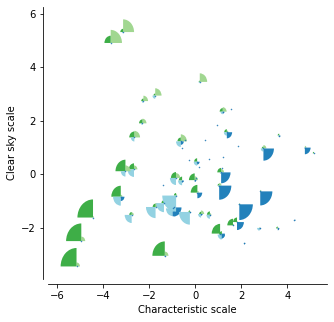

In [286]:
pcs = [0,1]
plot_wedges_sgff(ds_pca_date[pcs],
                 pcs,
                 ds_sgff_date, 
                 xlab='Cloud scale',
                 ylab='Clear sky scale')

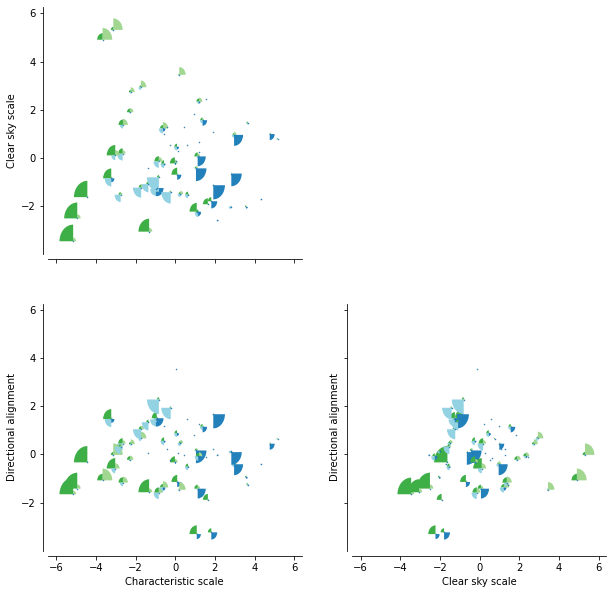

In [322]:
fig, axs = plt.subplots(nrows=2,ncols=2,sharex=True,sharey=True,figsize=(10,10))

labs = ['Characteristic scale', 'Clear sky scale', 'Directional alignment']

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        if j <= i:
            xlab = labs[j] if i == len(labs)-2 else None
            ylab = labs[i+1] if j == 0 else None
            pcs = [j,i+1]
            plot_wedges_sgff(ds_pca_date[pcs], pcs, ds_sgff_date, ax=axs[i,j], xlab=xlab, ylab=labs[i+1])
        else:
            fig.delaxes(axs[i,j])